# Introduction to gradients and automatic differentiation

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) is useful for implementing machine learning algorithms such as [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training neural networks.

In this guide, you will explore ways to compute gradients with TensorFlow, especially in eager execution.

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2023-03-03 11:01:35.633187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Computing Gradients

To differentiate automatically, TensorFlow needs to keep track of operations that are executed in order to compute the final result. This is done by using a [tape](https://www.tensorflow.org/api_docs/python/tf/Tape).
To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

## Gradient tapes

TensorFlow provides the `tf.GradientTape` API for automatic differentiation - that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

A `tf.GradientTape` can only compute one gradient; subsequent calls throw a runtime error.
It works like a [context manager](https://en.wikipedia.org/wiki/Context_manager) and should be used to compute gradients in a `tf.function` or in eager execution.
It is also possible to compute nested gradients - that is, to compute the gradient of a function that itself computes a gradient.

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

2023-03-03 11:01:38.795766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 11:01:38.797309: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


One thing to keep in mind is that the resources held by a GradientTape are released as soon as `GradientTape.gradient()` method is called. For long-running computations, you can compute the gradient over multiple calls to `gradient()` - for example, to do gradient descent by steps.

Once you've recorded some operations, use `GradientTape.gradient()` to compute the gradient of a "recorded" computation with respect to some inputs. By default, `GradientTape.gradient()` will compute the gradient of the computation with respect to all `tf.Variable`s that were used to compute the result. If you want to compute the gradient with respect to some other `tf.Tensor`s, you can pass the `sources` argument to `GradientTape.gradient()`.

In [4]:
# Derivative of y with respect to the original input tensor x
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [5]:
# Example with tensor input
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')

x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

The `persistent` argument to `GradientTape()` allows multiple calls to `GradientTape.gradient()`. This is useful for more advanced use cases, such as computing the gradient of the gradient of a function.

To get the gradient of `loss` with respect to **weights** and **biases**, you cam pass both as sources to `GradientTape.gradient()`. The tape is flexible about how sources are passed and will accept any nested combination of lists, tuples, and dictionaries and will return the gradients in the same structure (see [tf.nest](https://www.tensorflow.org/api_docs/python/tf/nest)).

In [6]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print(w.shape)
print(dl_dw.shape)

print(dl_dw)
print(dl_db)

(3, 2)
(3, 2)
tf.Tensor(
[[ -3.7757063  -6.771224 ]
 [ -7.5514126 -13.542448 ]
 [-11.327119  -20.313671 ]], shape=(3, 2), dtype=float32)
tf.Tensor([-3.7757063 -6.771224 ], shape=(2,), dtype=float32)


Here it is the same example, but using a dictionary as sources.

In [7]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
print(grad['w'])
print(grad['b'])

tf.Tensor(
[[ -3.7757063  -6.771224 ]
 [ -7.5514126 -13.542448 ]
 [-11.327119  -20.313671 ]], shape=(3, 2), dtype=float32)
tf.Tensor([-3.7757063 -6.771224 ], shape=(2,), dtype=float32)


## Gradients with respect to a model

The `tf.GradientTape` API can be used to compute gradients with respect to a model's parameters.
It's common to collect `tf.Variables` into a `tf.Module` or one of its subclasses. In most cases, you will want to calculate gradients with respect to a **model's trainable variables**. Since all subclasses of `tf.Module` aggregate their variables in the `Module.trainable_variables` property, you can calculate these gradients in a few lines of code:

In [8]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    # Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# Backward pass
grad = tape.gradient(loss, layer.trainable_variables)

In [9]:
for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {var.shape}')
    print(f'{g}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
[[0.9049958 0.       ]
 [1.8099916 0.       ]
 [2.7149873 0.       ]], shape: (3, 2)
dense/bias:0, shape: (2,)
[0.9049958 0.       ], shape: (2,)


## Controlling what the tape watches

By default, a `tf.GradientTape` watches all trainable `tf.Variables` that are accessed inside the context.
It records all operations after accessing a trainable variable.
The reasons for this are:
* It's common to want to compute the gradient of a loss with respect to all trainable variables.
* The tape needs to know which operations to record in the forward pass to calculate the gradients in the backwards pass.
* The tape holds referensed to intermediate outputs, so you don't need to record unnecessary operations.

In [10]:
# For example, the following fails to calculate a gradient because the tf.Tensor is not "watched" by default, and the tf.Variable is not trainable:

x0 = tf.Variable(3.0, name='x0')
x1 = tf.Variable(4.0, name='x1', trainable=False) # not trainable
x2 = tf.Variable(5.0, name='x2') + 1.0 # x2 is not a variable, but a tensor
x3 = tf.constant(3.0, name='x3') # x3 is not a variable, but a tensor

with tf.GradientTape() as tape:
    y = x0**2 + x1**2 + x2**2 + x3**2

grad = tape.gradient(y, {'x0': x0, 'x1': x1, 'x2': x2, 'x3': x3})
for g in grad:
    print(f'{g}: {grad[g]}')

x0: 6.0
x1: None
x2: None
x3: None


You can list the variables being watched by a tape using `GradientTape.watched_variables()`.

In [11]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.
To record gradients with respect to a tf.Tensor, you need to call `GradientTape.watch(x)`:

In [12]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

dy_dx = tape.gradient(y, x)
print(f'x: {dy_dx.numpy()}')

with tf.GradientTape() as tape:
    tape.watch([x0, x1, x2, x3])
    y = x0**2 + x1**2 + x2**2 + x3**2

grad = tape.gradient(y, {'x0': x0, 'x1': x1, 'x2': x2, 'x3': x3})
for g in grad:
    print(f'{g}: {grad[g]}')

x: 6.0
x0: 6.0
x1: 8.0
x2: 12.0
x3: 6.0


Conversely, to disable the default behavior of watching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [13]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.sigmoid(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

grad = tape.gradient(ys, {'x0': x0, 'x1': x1})
for g in grad:
    print(f'{g}: {grad[g]}')


x0: None
x1: 4.5416676584864035e-05


## Intermediate results
You can also request the gradient of a computation with respect to intermediate results. Computed inside the `tf.GradientTape` context, intermediate results are available to the `GradientTape` for the duration of that context. The gradient of the computation with respect to an intermediate result can be calculated by passing the intermediate `tf.Tensor` to `GradientTape.gradient()` as source.

In [14]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
    z = y * y

# Use the same tape to compute the derivative of z with respect to the intermediate value y.
print(tape.gradient(z, y).numpy())

18.0


As said before, by default, the resources held by a `tf.GradientTape` are released as soon as the `tf.GradientTape.gradient` method is called. To compute **multiple gradients** over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected. For example:

[[  4.  32.]
 [108. 256.]]
[[2. 4.]
 [6. 8.]]


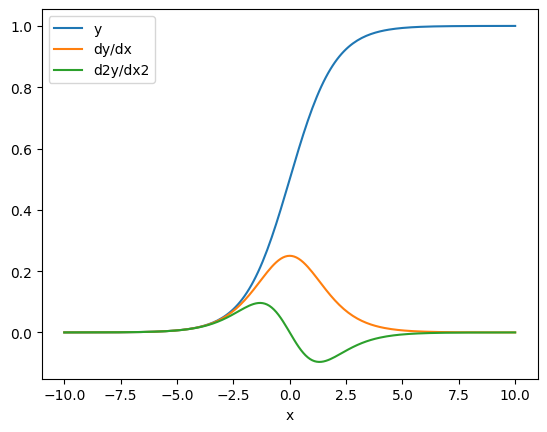

In [44]:
x = tf.constant([[1., 2.], [3., 4.]])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

print(tape.gradient(z, x).numpy())
print(tape.gradient(y, x).numpy())

# Compute second-order derivative
x = tf.linspace(-10., 10., 200+1)
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)
    dy_dx = tape.gradient(y, x)
dy2_dx2 = tape.gradient(dy_dx, x)

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.plot(x, dy2_dx2, label='d2y/dx2')
plt.legend()
_ = plt.xlabel('x')

If you use a persisted gradient, you can drop the reference to the tape when you are done with it, otherwise it will leak memory.

In [45]:
del tape

## Notes on performance
1. If you are computing the gradient of a scalar-valued function, you can omit the `sources` argument to `GradientTape.gradient()`. This is because there is only one element in the gradient vector, and hence it is the gradient itself.

2. If you are computing the gradient of a vector-valued function, you can pass a `tf.Tensor` with shape `[N]` as the source. This is equivalent to passing a list of `N` `tf.Tensor`s with shape `[]` as the source, but may be more efficient.

3. If you are computing the gradient of a matrix-valued function, you can pass a `tf.Tensor` with shape `[M, N]` as the source. This is equivalent to passing a list of `M` `tf.Tensor`s with shape `[N]` as the source, but may be more efficient.

4. If you are computing the gradient of a function with respect to a list of variables, you can pass a list of `tf.Tensor`s as the source. This is equivalent to passing a list of `tf.Tensor`s with shape `[1]` as the source, but may be more efficient.

6. There is a **tiny overhead** associated with doing operations inside a gradient tape context. For most eager execution this will not be a noticeable cost, but you should still use tape context around the areas only where it is required. 

7. Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backwards pass. For efficiency, some ops (like **ReLU**) don't need to keep their intermediate results and they are pruned during the forward pass. However, if you use `persistent=True` on your tape, **nothing is discarded** and your peak memory usage will be higher.

## Gradients of non-scalar targets
A gradient is fundamentally an operation on a scalar.

In [17]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if you ask for the gradient of multiple targets, the result for each source is:
* The gradient of the sum of the targets, or equivalently
* The sum of the gradients of each target.

In [18]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy()) # dy0/dx + dy1/dx

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [19]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If you need a separate gradient for each item, refer to [Jacobians](https://www.tensorflow.org/guide/advanced_autodiff#jacobians).

In some cases you can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element with respect to its input-element, since each element is independent:

In [24]:
x = tf.linspace(-10., 10., 200+1)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)
print(x.shape)
print(dy_dx.shape)

(201,)
(201,)


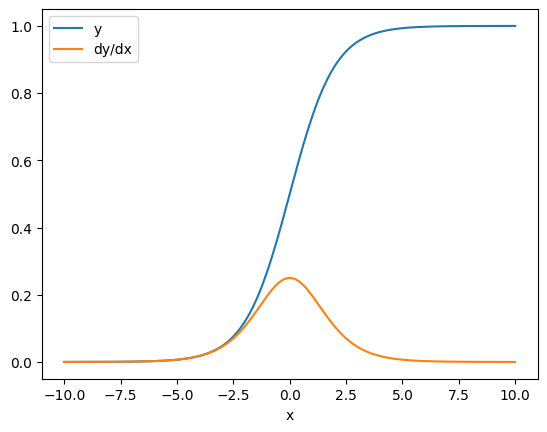

In [21]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## Control Flow

The `tf.GradientTape` API can be used to compute gradients of loops and conditionals.
Because the tape records operations as they are executed, Python control flow (using `if` and `while` statements) is naturally handled.
Here a different variable is used on each branch of an `if`. The gradient only connects to the variable that was used:

In [47]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2
    
dv0, dv1 = tape.gradient(result, [v0, v1])

print(f'dv0: {dv0}')
print(f'dv1: {dv1}')

dv0: 1.0
dv1: None


Just remember that the control statements themselves are not differentiable, so they are **invisible** to gradient-based optimizers.

Depending on the value of `x` in the above example, the tape either records `result = v0` or `result = v1**2`. The gradient with respect to `x` is always `None`.

In [48]:
dx = tape.gradient(result, x)
print(f'dx: {dx}')

dx: None


## Cases where gradient returns **None**
This occurs when the gradient is not defined for a particular source. This can happen for a number of reasons, including the following:

In [51]:
# 1. The target is not connected to the source
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape(persistent=True) as tape:
    z = y * y
grad = tape.gradient(z, {'y': y, 'x': x})
print(f'dz/dy: {grad["y"]}')
print(f'dz/dx: {grad["x"]}')

dz/dy: 6.0
dz/dx: None


In [58]:
# 2. The source is inadvertently not a tf.Variable
x = tf.Variable([2.0])
for epoch in range(2):
    with tf.GradientTape() as tape:
        y = [x**2, x**3]
    dy_dx = tape.gradient(y, x)
    print(f'epoch: {epoch}, {type(x).__name__}: {dy_dx}')
    x = x + 1.0 # x is no more a tf.Variable

epoch: 0, ResourceVariable: [16.]
epoch: 1, EagerTensor: None


In [61]:
# 3. You did calculations outside of tensorflow
x = tf.Variable([[1., 2.],
                 [3., 4.]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x**2
    y = np.mean(x2, axis=0) # this is calculated outside of tensorflow in numpy
    y = tf.reduce_mean(y, axis=0) # this is calculated in tensorflow and works fine becuase the numpy array is converted to a tensor
grad = tape.gradient(y, x)
print(grad)

# This may occur also when you import something from outside

None


In [63]:
# 4. Took gradients through an integer of string, which are not differentiable
x = tf.Variable(2) # The dtype of the watched tensor must be floating
with tf.GradientTape() as tape:
    y = x**2

grad = tape.gradient(y, x)
print(grad)


None


In [65]:
# 5. Took gradients through a stateful object, since the tape can only observe the current state and not the history of the stateful object
# Tensors are stateless, but tf.Variable is stateful and blocks the gradient
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    x1.assign_add(x0)
    y = x1**2 # y = (x0 + x1)**2, but the tape starts recording only x1 

grad = tape.gradient(y, {'x0': x0, 'x1': x1})
print(f'dy/dx0: {grad["x0"]}')
print(f'dy/dx1: {grad["x1"]}')

# Similarly, `tf.data.Dataset` and `tf.queue` are stateful and block the gradient

dy/dx0: None
dy/dx1: 6.0


## No gradient registered

Some `tf.Operations` are registered as being **non-differentiable** and will return `None`. Others have `no gradient registered`.

The [tf.raw_ops](https://www.tensorflow.org/api_docs/python/tf/raw_ops) page shows which low-level ops have gradients registered.

If you attempt to take a gradient through a float op that has no gradient registered the tape will `throw an error` instead of silently returning None. This way you know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustContrastv2`, which could have a gradient but the gradient is not implemented. If you try to take the gradient of the output of `tf.image.adjust_contrast` you will get an error.

If you are using a custom op, you may need to register a gradient function for it. See [Custom gradients](https://www.tensorflow.org/guide/advanced_autodiff#custom_gradients) for more information.

In [66]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)

try:
    grad = tape.gradient(new_image, [image, delta])
    print(grad)
    assert False # This should not be reached
except LookupError as e:
    print(f'LookupError: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


If you need to differentiate through this op, you'll either need to implement the gradient and register it (using `tf.RegisterGradient`) or re-implement the function using other ops.

## Zero instead of None

In some cases it would be convenient to get `0` instead of `None` for unconnected gradients. You can decide what to return when you have unconnected gradients using the `unconnected_gradients` argument:

In [68]:
x = tf.Variable([2.0, 2.0])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y * y

grad = tape.gradient(z, {'x': x, 'y': y}, unconnected_gradients=tf.UnconnectedGradients.ZERO)
print(f'dz/dx: {grad["x"]}')
print(f'dz/dy: {grad["y"]}')

dz/dx: [0. 0.]
dz/dy: 6.0
